In [191]:
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from scipy import optimize
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator

### From James Original Code, Loads and Preprocess Signal Data From File

In [192]:
with open("2022-11-05_23-29-51__2022-11-06_11-20-39.txt","r") as eventfile:
    df = pd.read_json(eventfile, lines=True)
df['stop_time'] = pd.to_datetime(df['stop_time'])
df.set_index('stop_time', inplace=True)

### Create All Empty Lists

In [193]:
# Store fit results
fit_results = []

# Make Time_steps list
time = df['pol'].index

# Create lists for Gaussian Variables
amp1_list, amp2_list, amp3_list = [], [], []
cen1_list, cen2_list, cen3_list = [], [], []
wid1_list, wid2_list, wid3_list = [], [], []

amp1_error, amp2_error, amp3_error = [], [], []
cen1_error, cen2_error, cen3_error = [], [], []
wid1_error, wid2_error, wid3_error = [], [], []


### Define Gaussian(s)

In [194]:
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2))

def three_gaussians(x, *params):
    return sum(gaussian(x, *params[i:i+3]) for i in range(0, 9, 3))

### Fit and Plot Individual Curve

In [195]:
def plot_pol_array_with_fit(index):
    plt.figure(figsize=(10, 6))
    signal_array = df.iloc[index]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    initial_guess = [
        mean_val / 3, len(signal_array) / 4, 100,
        mean_val / 3, len(signal_array) / 2, 100,
        mean_val / 3, 3 * len(signal_array) / 4, 100
    ]

    try:
        # Fit and get covariance matrix
        popt, pcov = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess, maxfev = 10000)
        perr = np.sqrt(np.diag(pcov))  # <-- Extract uncertainties

        # Print parameters and uncertainties
        for i in range(3):
            amp, cen, wid = popt[i*3:i*3+3]
            amp_error, cen_error, wid_error = perr[i*3:i*3+3]
            print(f"Gaussian {i+1}:")
            print(f"Amplitude = {amp:.4f} ± {amp_error:.4f}")
            print(f"Center    = {cen:.2f} ± {cen_error:.2f}")
            print(f"Width     = {wid:.2f} ± {wid_error:.2f}")

        # Append results
        fit_results.append({
            'index': index,
            'time': df.index[index],
            'pol': df.iloc[index]['pol'],
            'params': popt
        })

        # Plot original and fit
        plt.plot(x_data, signal_array, label='Original Signal', linewidth=2)
        plt.plot(x_data, three_gaussians(x_data, *popt), '--', color='red', label='Total Fit')

        # Plot individual Gaussians
        colors = ['blue', 'green', 'purple']
        for i in range(3):
            amp, cen, wid = popt[i*3:i*3+3]
            g = gaussian(x_data, amp, cen, wid)
            label = f'Gaussian{i+1}: Amp={amp:.4f}, Cen={cen:.2f}, Wid={abs(wid):.2f}'
            plt.plot(x_data, g, linestyle=':', color=colors[i], label=label)

        plt.title(f"Signal {index} | Polarization: {df.iloc[index]['pol']:.2f}")
        plt.xlabel("Index")
        plt.ylabel("Signal")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    except RuntimeError:
        print(f"Fit failed for row {index}")

# Create Slider

In [196]:
interact(plot_pol_array_with_fit,
         index=IntSlider(min=8, max=len(df)-1, step=1, value=9, description='Row Index:'))

interactive(children=(IntSlider(value=9, description='Row Index:', max=131, min=8), Output()), _dom_classes=('…

<function __main__.plot_pol_array_with_fit(index)>

### TITLE

In [210]:
lowbound = (-np.inf, -np.inf, 0, -np.inf, -np.inf, 0, -np.inf, -np.inf, 0)
upbound = (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf,)


for i in range(len(df)):
    
    # ...
    signal_array = df.iloc[i]['rescurve']
    x_data = np.arange(len(signal_array))

    mean_val = np.mean(signal_array)
    initial_guess = [
        mean_val / 3, len(signal_array) / 4, 100,
        mean_val / 3, len(signal_array) / 2, 100,
        mean_val / 3, 3 * len(signal_array) / 4, 100
    ]

    try:
        popt, pcov = curve_fit(three_gaussians, x_data, signal_array, p0=initial_guess, bounds=(lowbound, upbound), maxfev=10000)
        perr = np.sqrt(np.diag(pcov))  # <-- Extract uncertainties

        model = three_gaussians(x_data, *popt)
        residuals = signal_array - model
        sigma = np.std(residuals, ddof=1)

        if sigma <= 0 or np.isnan(sigma):
            continue  # Skip unreliable fits

        chi2 = np.sum((residuals / sigma) ** 2)


        fit_results.append({
            'index': i,
            'time': df.index[i],
            'pol': df.iloc[i]['pol'],
            'params': popt,
            'errors': perr,
            'chi2': chi2
    })
    except RuntimeError:
        continue


In [211]:
print(fit_df[['time', 'chi2']])

                                time        chi2
0   2022-11-06 01:45:40.166998+00:00         NaN
1   2022-11-06 01:33:44.073311+00:00  512.002037
2   2022-11-06 01:35:03.293235+00:00  512.000001
3   2022-11-06 01:36:22.513498+00:00  512.002612
4   2022-11-06 01:37:41.729688+00:00  512.019704
..                               ...         ...
128 2022-11-06 04:21:29.677975+00:00  512.501258
129 2022-11-06 04:22:48.898293+00:00  512.621103
130 2022-11-06 04:24:08.116986+00:00  512.634812
131 2022-11-06 04:25:27.340763+00:00  512.563208
132 2022-11-06 04:26:46.565984+00:00  512.579777

[133 rows x 2 columns]


### Create Plot of Amplitudes vs Time

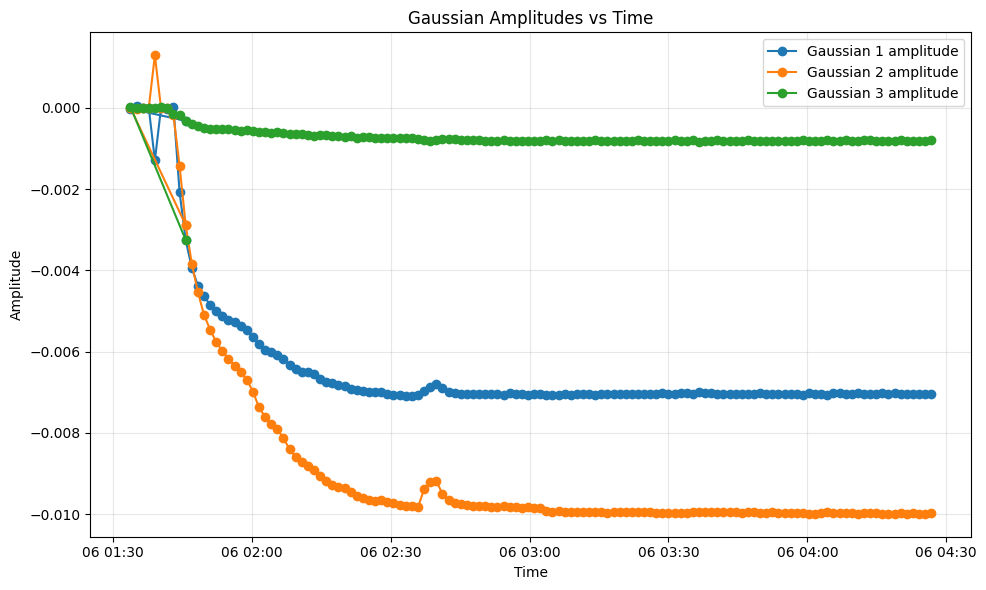

In [199]:
# Convert fit results to DataFrame
fit_df = pd.DataFrame(fit_results)

plt.figure(figsize=(10, 6))
for i in range(3):
    amps = fit_df['params'].apply(lambda p: p[i*3] if isinstance(p, (list, np.ndarray)) else np.nan)
    amp_error, cen_error, wid_error = perr[i*3:i*3+3]
    plt.plot(fit_df['time'], amps, 'o-', label=f'Gaussian {i+1} amplitude')
    #plt.errorbar(...)
    
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Gaussian Amplitudes vs Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Create Plot of Centers vs Time

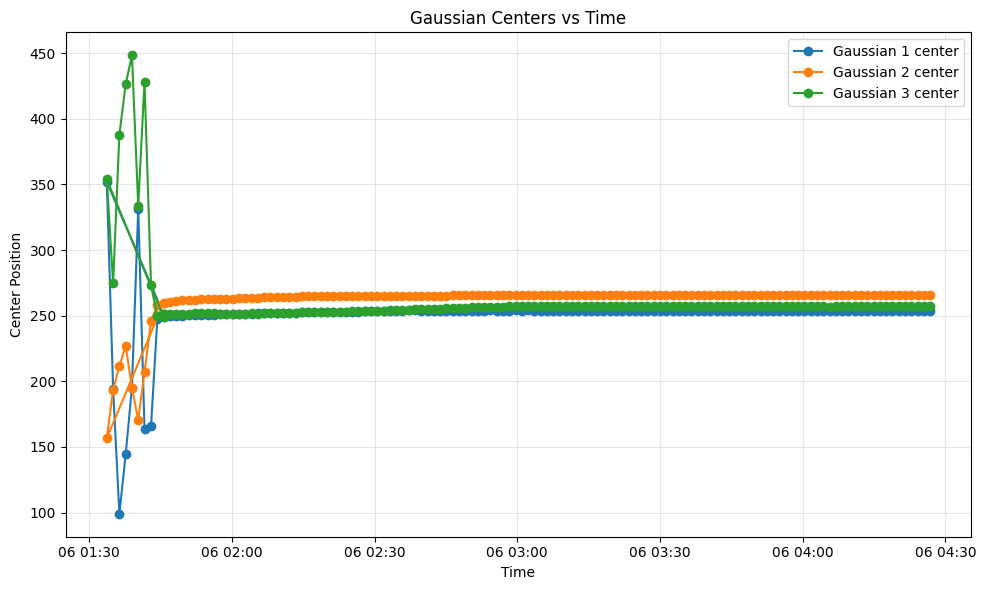

In [200]:
plt.figure(figsize=(10, 6))
for i in range(3):
    centers = fit_df['params'].apply(lambda p: p[i*3+1] if isinstance(p, (list, np.ndarray)) else np.nan)
    plt.plot(fit_df['time'], centers, 'o-', label=f'Gaussian {i+1} center')

plt.xlabel('Time')
plt.ylabel('Center Position')
plt.title('Gaussian Centers vs Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Create Plot of Widths vs Time

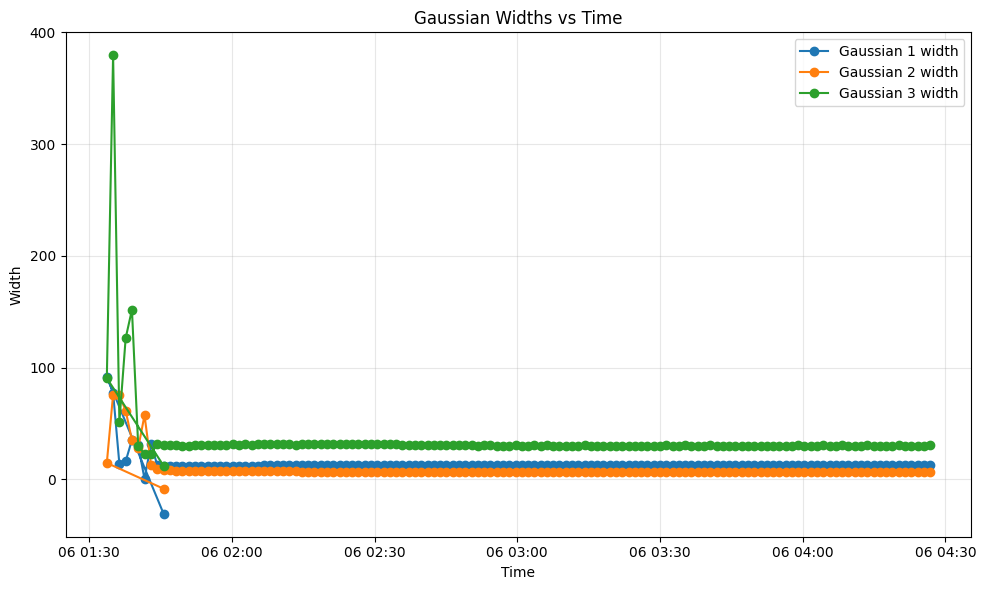

In [201]:
plt.figure(figsize=(10, 6))
for i in range(3):
    widths = fit_df['params'].apply(lambda p: p[i*3+2] if isinstance(p, (list, np.ndarray)) else np.nan)
    plt.plot(fit_df['time'], widths, 'o-', label=f'Gaussian {i+1} width')

plt.xlabel('Time')
plt.ylabel('Width')
plt.title('Gaussian Widths vs Time')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Create Amplitudes vs Time Plot (with Error Bars)

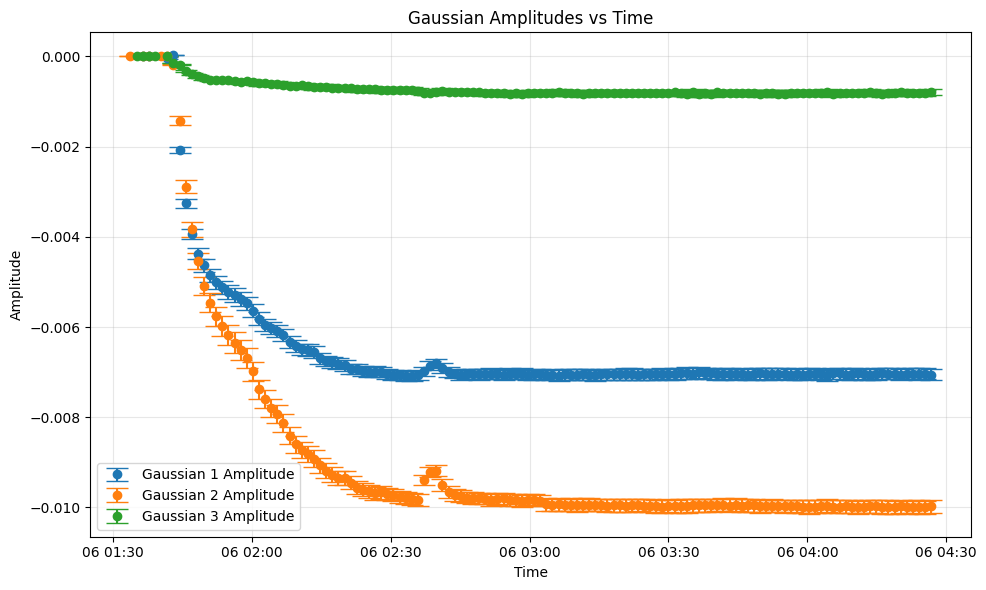

In [202]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(10, 6))
for i in range(3):
    amps = fit_df['params'].apply(lambda p: p[i*3] if isinstance(p, (list, np.ndarray)) else np.nan)
    amp_errors = fit_df['errors'].apply(lambda e: e[i*3] if isinstance(e, (list, np.ndarray)) else np.nan)

    # mask filters out outliers/bad values
    mask = (amp_errors < 0.005) & (~np.isnan(amp_errors)) & (~np.isinf(amp_errors))
    filtered_amps = amps.where(mask, np.nan)
    filtered_errors = amp_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df['time'], filtered_amps, yerr=filtered_errors,
        fmt='o', capsize=8, label=f'Gaussian {i+1} Amplitude', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Gaussian Amplitudes vs Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Create Centers vs Time Plot (with Error Bars)

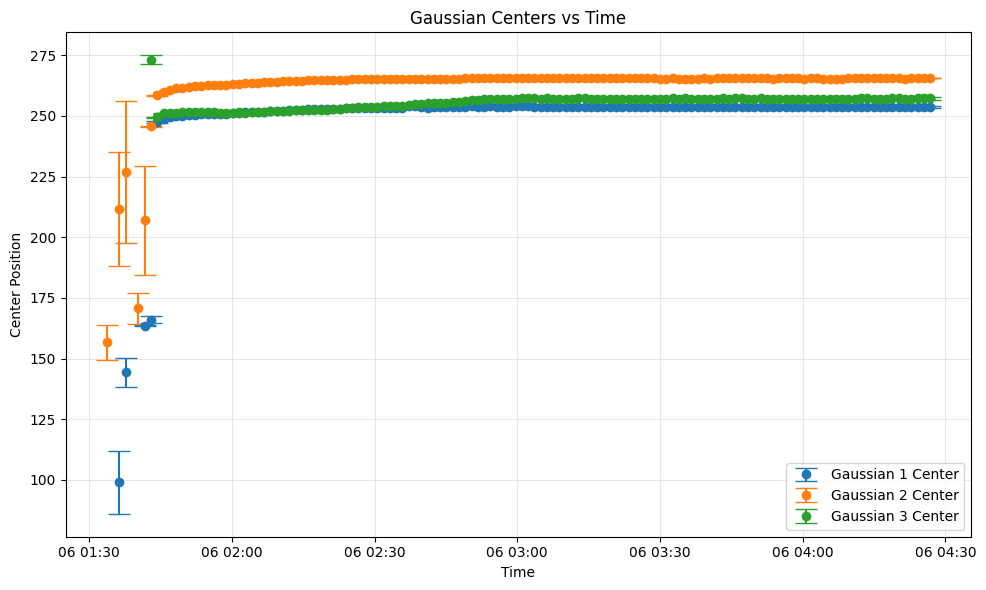

In [203]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(10, 6))
for i in range(3):
    centers = fit_df['params'].apply(lambda p: p[i*3 + 1] if isinstance(p, (list, np.ndarray)) else np.nan)
    center_errors = fit_df['errors'].apply(lambda e: e[i*3 + 1] if isinstance(e, (list, np.ndarray)) else np.nan)

    # mask filters out outliers/bad values
    mask = (centers < 300) & (center_errors < 300) & (~np.isnan(center_errors)) & (~np.isinf(center_errors))
    filtered_centers = centers.where(mask, np.nan)
    filtered_errors = center_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df['time'], filtered_centers, yerr=filtered_errors,
        fmt='o', capsize=8, label=f'Gaussian {i+1} Center', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Center Position")
plt.title("Gaussian Centers vs Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Create Widths vs Time Plot (with Error Bars)

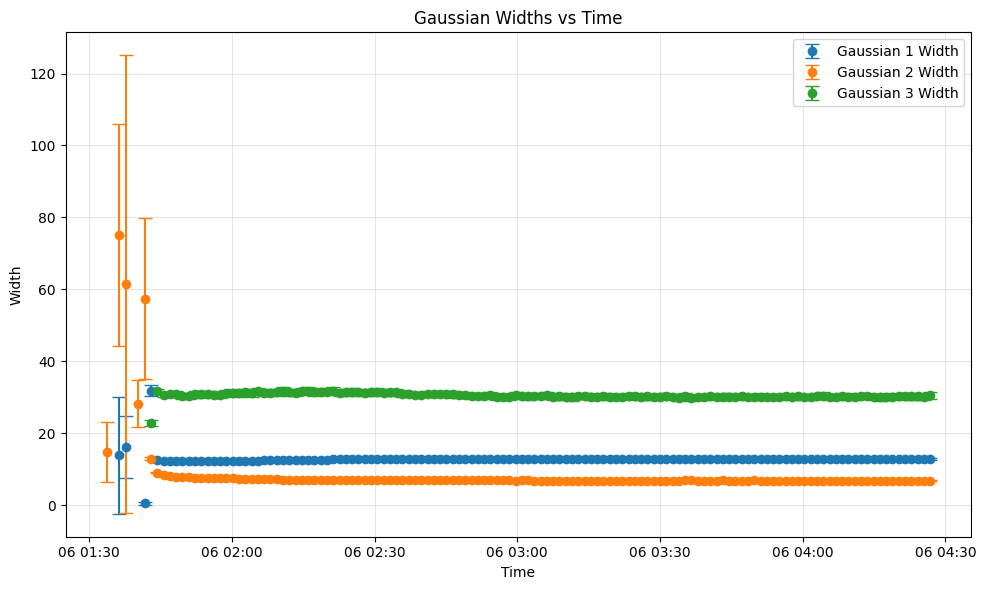

In [204]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(10, 6))
for i in range(3):
    widths = fit_df['params'].apply(lambda p: p[i*3 + 2] if isinstance(p, (list, np.ndarray)) else np.nan)
    width_errors = fit_df['errors'].apply(lambda e: e[i*3 + 2] if isinstance(e, (list, np.ndarray)) else np.nan)

    # mask filters out outliers/bad values
    mask = (width_errors < 200) & (~np.isnan(width_errors)) & (~np.isinf(width_errors))
    filtered_widths = widths.where(mask, np.nan)
    filtered_errors = width_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df['time'], filtered_widths, yerr=filtered_errors,
        fmt='o', capsize=5, label=f'Gaussian {i+1} Width', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Width")
plt.title("Gaussian Widths vs Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

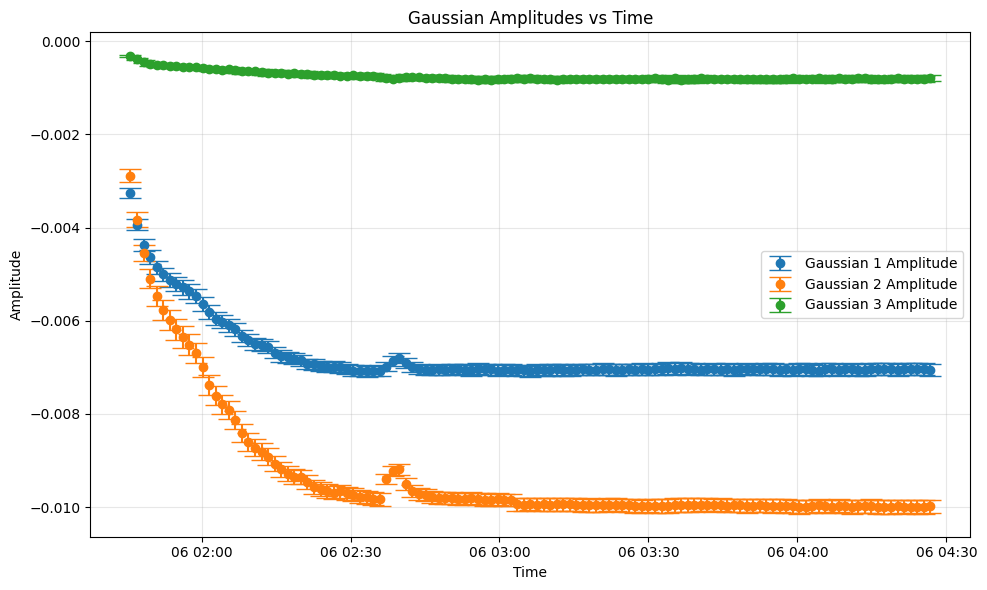

In [205]:
# Filter fit_df to only include data after 1:45
start_time = pd.to_datetime("2022-11-06 01:45:00").tz_localize("UTC")
fit_df_late = fit_df[fit_df['time'] >= start_time]

# Amplitude Plot
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))
for i in range(3):
    amps = fit_df_late['params'].apply(lambda p: p[i*3] if isinstance(p, (list, np.ndarray)) else np.nan)
    amp_errors = fit_df_late['errors'].apply(lambda e: e[i*3] if isinstance(e, (list, np.ndarray)) else np.nan)

    mask = (amp_errors < 0.005) & (~np.isnan(amp_errors)) & (~np.isinf(amp_errors))
    filtered_amps = amps.where(mask, np.nan)
    filtered_errors = amp_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df_late['time'], filtered_amps, yerr=filtered_errors,
        fmt='o', capsize=8, label=f'Gaussian {i+1} Amplitude', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Gaussian Amplitudes vs Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


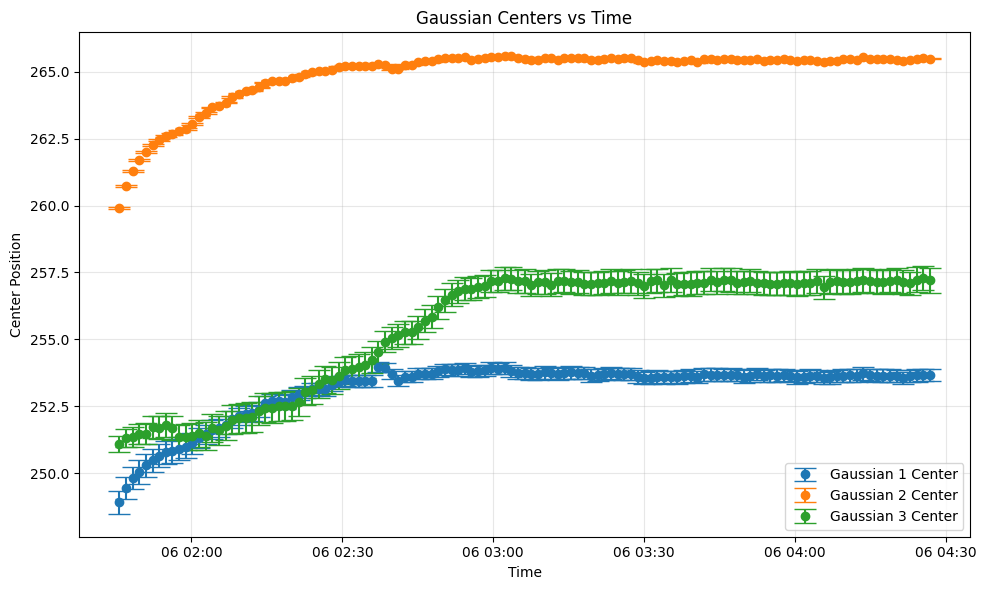

In [206]:
# Center Plot
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))
for i in range(3):
    centers = fit_df_late['params'].apply(lambda p: p[i*3 + 1] if isinstance(p, (list, np.ndarray)) else np.nan)
    center_errors = fit_df_late['errors'].apply(lambda e: e[i*3 + 1] if isinstance(e, (list, np.ndarray)) else np.nan)

    mask = (centers < 300) & (center_errors < 300) & (~np.isnan(center_errors)) & (~np.isinf(center_errors))
    filtered_centers = centers.where(mask, np.nan)
    filtered_errors = center_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df_late['time'], filtered_centers, yerr=filtered_errors,
        fmt='o', capsize=8, label=f'Gaussian {i+1} Center', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Center Position")
plt.title("Gaussian Centers vs Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


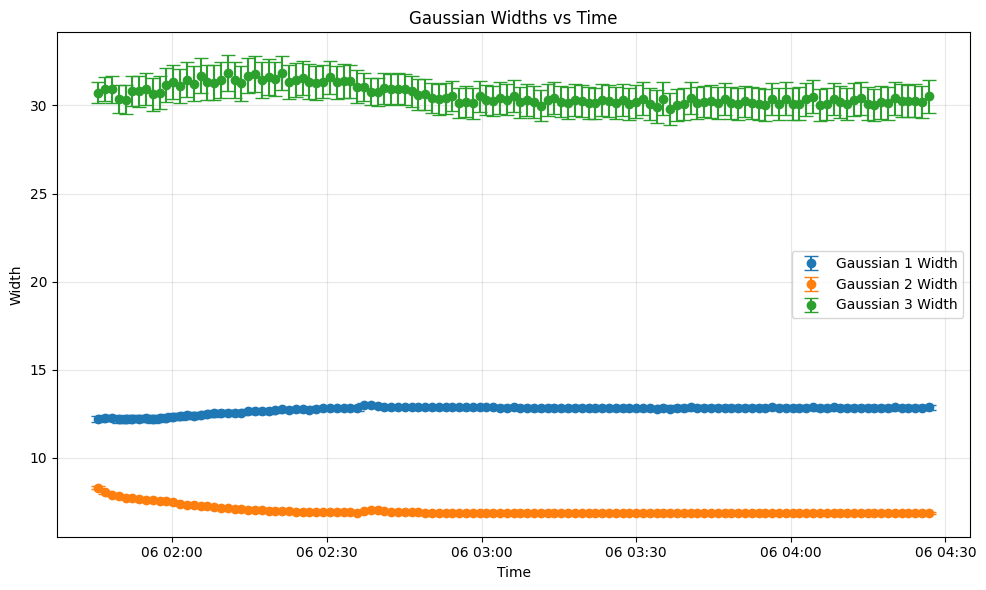

In [207]:
# Width Plot
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))
for i in range(3):
    widths = fit_df_late['params'].apply(lambda p: p[i*3 + 2] if isinstance(p, (list, np.ndarray)) else np.nan)
    width_errors = fit_df_late['errors'].apply(lambda e: e[i*3 + 2] if isinstance(e, (list, np.ndarray)) else np.nan)

    mask = (width_errors < 200) & (~np.isnan(width_errors)) & (~np.isinf(width_errors))
    filtered_widths = widths.where(mask, np.nan)
    filtered_errors = width_errors.where(mask, np.nan)

    plt.errorbar(
        fit_df_late['time'], filtered_widths, yerr=filtered_errors,
        fmt='o', capsize=5, label=f'Gaussian {i+1} Width', color=colors[i]
    )

plt.xlabel("Time")
plt.ylabel("Width")
plt.title("Gaussian Widths vs Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [208]:
print(fit_df[['time', 'chi2']])

                                time        chi2
0   2022-11-06 01:45:40.166998+00:00         NaN
1   2022-11-06 01:33:44.073311+00:00  512.002037
2   2022-11-06 01:35:03.293235+00:00  512.000001
3   2022-11-06 01:36:22.513498+00:00  512.002612
4   2022-11-06 01:37:41.729688+00:00  512.019704
..                               ...         ...
128 2022-11-06 04:21:29.677975+00:00  512.501258
129 2022-11-06 04:22:48.898293+00:00  512.621103
130 2022-11-06 04:24:08.116986+00:00  512.634812
131 2022-11-06 04:25:27.340763+00:00  512.563208
132 2022-11-06 04:26:46.565984+00:00  512.579777

[133 rows x 2 columns]


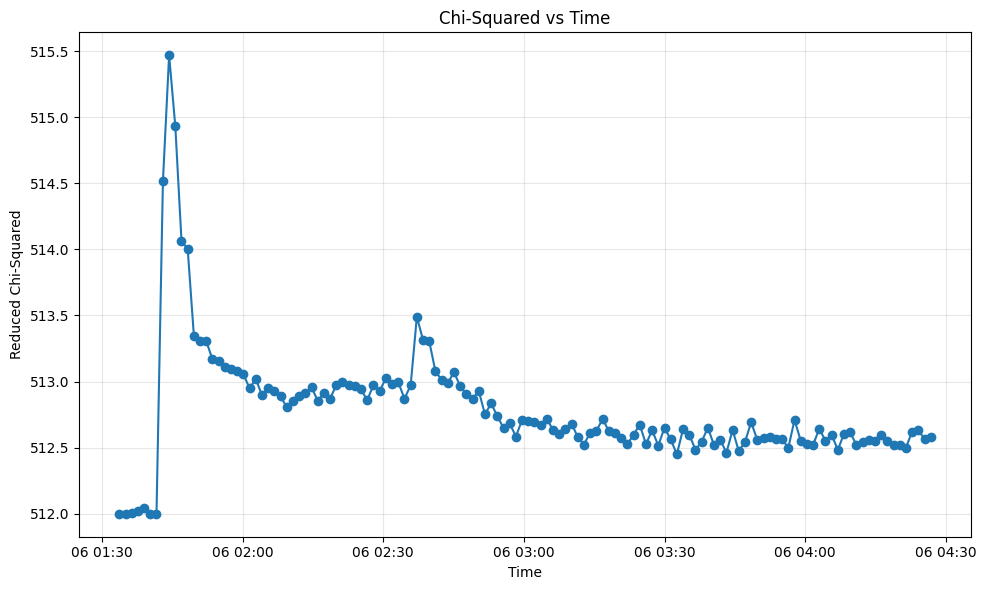

In [212]:
plt.figure(figsize=(10, 6))
plt.plot(fit_df['time'], fit_df['chi2'], 'o-')
plt.xlabel("Time")
plt.ylabel("Reduced Chi-Squared")
plt.title("Chi-Squared vs Time")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
